<a href="https://colab.research.google.com/github/MahmoudAyach496/Pose_speech/blob/main/Final_Year_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **PART 1**


*   In this part, we will do secret word detection
*   The secret word in this project:"Go"
*   I search online for audio dataset that contain the word "Go" and i found one in kaggle
*   https://www.kaggle.com/code/ajaybhatt/speech-classification/input
*   I will train a classifier than detect if a word is  "Go" or not 'Go"



In [ ]:
import pandas as pd  # Importing pandas for data manipulation and analysis
import numpy as np  # Importing numpy for numerical operations
import matplotlib.pyplot as plt  # Importing matplotlib for plotting graphs
import seaborn as sns  # Importing seaborn for enhanced data visualization

import os  # Importing os for operating system dependent functionality
import librosa  # Importing librosa for audio processing

import IPython.display as ipd  # Importing IPython.display for audio playback in Jupyter notebooks
from scipy.io import wavfile  # Importing wavfile for reading and writing WAV files
from google.colab import drive  # Importing drive to mount Google Drive in Colab
drive.mount('/content/drive')  # Mounting Google Drive to access files


Mounted at /content/drive


# write comments in all section
# draw a diagram


##### Plot the audio wave of  one of the word of the dataset

samples:(16000,)
sample_rate:16000


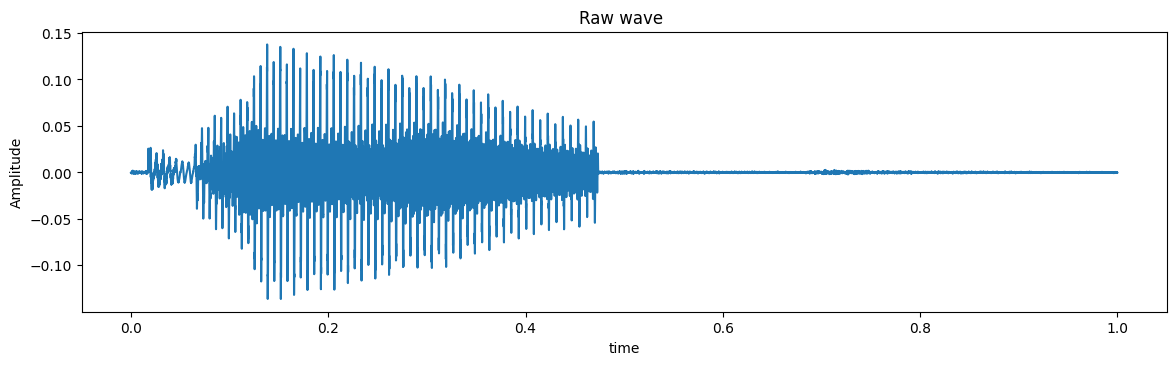

In [ ]:
# Loading and plotting audio data to analyze its waveform characteristics.
# Loading an audio file at a sampling rate of 16000 Hz to visualize its detailed waveform characteristics.

train_audio_path = '/content/drive/MyDrive/project_dataset/speech_recognition/go/102.wav'
samples, sample_rate = librosa.load(train_audio_path, sr = 16000)
print('samples:{}'.format(samples.shape))
print('sample_rate:{}'.format(sample_rate))
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave ')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)


###### plot the data distribution

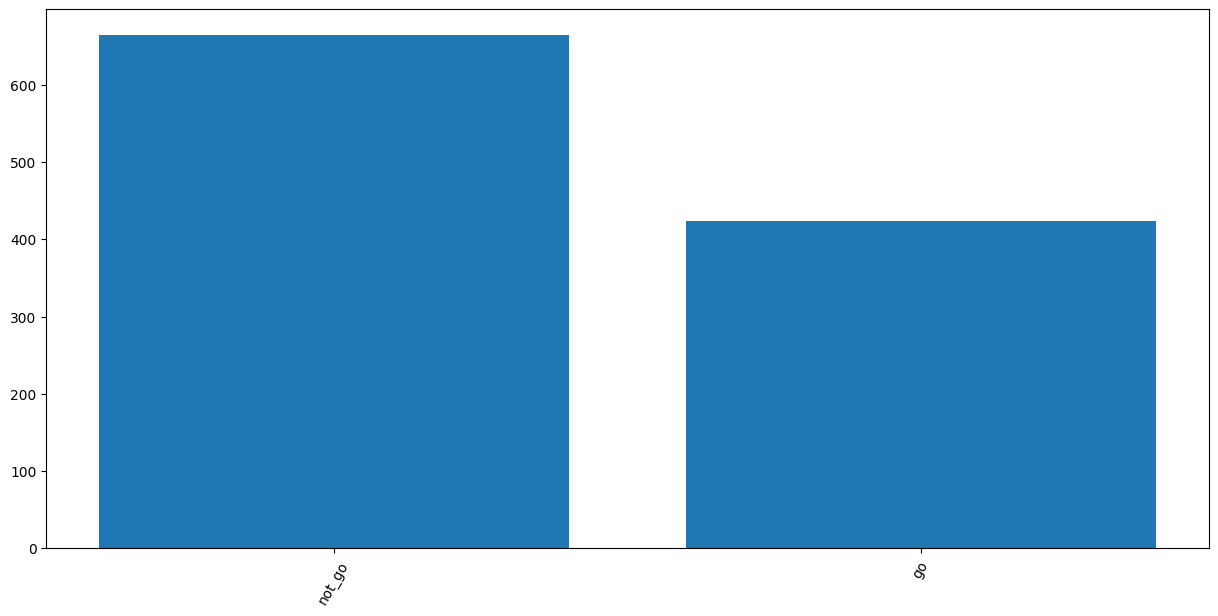

In [ ]:
# Visualizing the distribution of audio files across  2 different categories (go/not_go) in a bar chart.
plt.rcParams['figure.figsize']=(15,7)
train_loc='/content/drive/MyDrive/project_dataset/speech_recognition'
labels=os.listdir(train_loc)
labels
count_lis=[len(os.listdir(train_loc+'/{}'.format(i))) for i in labels]
index=np.arange(0,len(count_lis))
plt.bar(index,count_lis)
plt.xticks(index,labels,rotation=60)
plt.show()


From this bar chart we can conclude the distribution of not_go(from different voices of smile,happy) .. and that is arround 650 waves despite the go distribution that is arround 450 waves

###### prepare the data and the lables

In [ ]:
# Loading, preprocessing, and collecting WAV files and their labels, ensuring each sample is exactly 8000 samples long.
# Setting the sampling rate to 8000 Hz and ensuring each audio file has exactly 8000 samples for uniform processing.

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_loc + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_loc + '/' + label + '/' + wav, sr = 8000)

        if(len(samples)== 8000) :
            all_wave.append(samples)
            all_label.append(label)


not_go
go


##### transform the labels to numerical

In [ ]:
from sklearn.preprocessing import LabelEncoder  # Importing LabelEncoder from sklearn for label encoding
from tensorflow.keras.utils import to_categorical  # Importing to_categorical from keras for one-hot encoding
#One-hot encoding is a method where each categorical value is converted into a binary vector with only one 'hot' (or active) element.
le = LabelEncoder()  # Creating an instance of LabelEncoder
labels_int = le.fit_transform(all_label)  # Transforming text labels into integer labels

# Now, convert integer labels to one-hot encoding
y1 = to_categorical(labels_int)  # Converting integer labels into one-hot encoded format


split data onto train and test

In [ ]:
from sklearn.model_selection import train_test_split  # Importing train_test_split to divide data into training and testing sets

# Splitting the dataset into training and testing sets, reshaping for compatibility with input requirements of models
X_train, X_test, y_train, y_test = train_test_split(
    np.array(all_wave).reshape(-1, 8000, 1),  # Reshaping the waveform data to match the expected input shape for the model
    np.array(y1),  # Using the one-hot encoded labels
    test_size=0.2,  # Setting aside 20% of the data as the test set
    shuffle=True  # Shuffling the data to ensure random distribution into train and test sets
)


build the dnn model to classify the audio

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D, Dropout  # Importing necessary layers for constructing a CNN
from tensorflow.keras.models import Model  # Importing Model class to create a functional API model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Importing callbacks for model training enhancements

# EarlyStopping will monitor the model's validation loss and stop training when it stops improving
# ModelCheckpoint will save the model after every epoch if it's the best seen so far




In [ ]:
inputs=Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)


outputs = Dense(2, activation='softmax')(conv)

model = Model(inputs, outputs)


decide the loss function and the algorithm

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])



early stopping


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=10,
                   min_delta=1e-4,
                   verbose=1,
                   restore_best_weights=True)

mc = ModelCheckpoint('best_model.keras',
                     monitor='val_accuracy',
                     mode='max',
                     save_best_only=True,
                     verbose=1)


training

In [ ]:
history=model.fit(X_train, y_train ,epochs=50, callbacks=[es,mc], batch_size=32, validation_data=(X_test,y_test))


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5790 - loss: 0.6842
Epoch 1: val_accuracy improved from -inf to 0.67890, saving model to best_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - accuracy: 0.5795 - loss: 0.6841 - val_accuracy: 0.6789 - val_loss: 0.6729
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.6288 - loss: 0.6551
Epoch 2: val_accuracy improved from 0.67890 to 0.71101, saving model to best_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - accuracy: 0.6296 - loss: 0.6546 - val_accuracy: 0.7110 - val_loss: 0.5963
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.6725 - loss: 0.6095
Epoch 3: val_accuracy improved from 0.71101 to 0.77064, saving model to best_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 388ms/step - accuracy: 0.6731 - loss: 0.6087 - val_accuracy: 0.7706 - val_loss: 0.5243
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7465 - loss: 0.5173
Epoch 4: val_accuracy improved from 0.

testing the train model

In [ ]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

# This function will be called later to save the audio file
def record_audio(filename):
  js = Javascript("""
    async function recordAudio() {
      // Prompt for permission, get the audio stream
      const stream = await navigator.mediaDevices.getUserMedia({audio: true});
      // Create a MediaRecorder instance
      const recorder = new MediaRecorder(stream);
      const data = [];

      // Push audio chunks into data array on dataavailable event
      recorder.ondataavailable = event => data.push(event.data);

      // Stop recording after 1 second and resolve the Promise
      recorder.start();
      await new Promise(resolve => setTimeout(resolve, 1000)); // Set duration here
      recorder.stop();

      // Wait for the stop event to ensure all the data
      return new Promise(resolve => recorder.onstop = resolve)
        .then(() => data);
    }

    async function saveAudio() {
      const data = await recordAudio();
      const audio = new Blob(data, { type: 'audio/webm' });
      const reader = new FileReader();
      reader.readAsDataURL(audio);
      reader.onloadend = () => {
        const base64AudioMessage = reader.result.split(',')[1];
        google.colab.kernel.invokeFunction('notebook.RecordAudio', [base64AudioMessage], {});
      };
    }
    saveAudio()
  """)
  display(js)

# This function will be invoked from JavaScript, receives the audio data as base64
def record_audio_base64(base64AudioMessage):
  audio_bytes = b64decode(base64AudioMessage)
  with open(filename, 'wb') as f:
    f.write(audio_bytes)

# Register the callback function that saves the audio
output.register_callback('notebook.RecordAudio', record_audio_base64)



record the audio live

In [ ]:
filename = '/content/test_audio_no.wav'  # Make sure the path exists or adjust accordingly
record_audio(filename)


<IPython.core.display.Javascript object>

listen to the audio

In [ ]:
from IPython.display import Audio
Audio(filename)


model decision

In [ ]:
import numpy as np
import librosa

# Function to load and preprocess the audio
def preprocess_audio(filename):
    # Load the audio file
    audio, sr = librosa.load(filename, sr=8000)  # Ensure audio is loaded at 8 kHz
    # If the audio is too long, trim it to the first 8000 samples
    if len(audio) > 8000:
        audio = audio[:8000]
    # If the audio is too short, pad it with zeros to 8000 samples
    elif len(audio) < 8000:
        audio = np.pad(audio, (0, 8000 - len(audio)), 'constant')
    # Reshape audio for the model
    audio = audio.reshape(1, 8000, 1)
    return audio



def predict(audio):
    classes=["go","not_go"]
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]



Result

In [ ]:
# Load and preprocess recorded audio
preprocessed_audio = preprocess_audio(filename)
prediction = predict(preprocessed_audio)
print("Predicted Text:", prediction)

/tmp/ipython-input-3455916046.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(filename, sr=8000)  # Ensure audio is loaded at 8 kHz
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Predicted Text: not_go


add performence metrics testing data

In [ ]:
# prompt: add performence metrics testing data

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

# Print the results
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


Test loss: 0.12860344350337982
Test accuracy: 0.9541284441947937


#**PART 2**

### Part 1: image classfier: correct Pose vs Neutral:
- upload the dataset
-  generate the pose
- Training the classfier
- do some example prediction

In [1]:
!pip install mediapipe opencv-python

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


File: /content/drive/MyDrive/project_dataset/pose_detection/postive/Photo on 15.03.24 at 15.13 #2.jpg


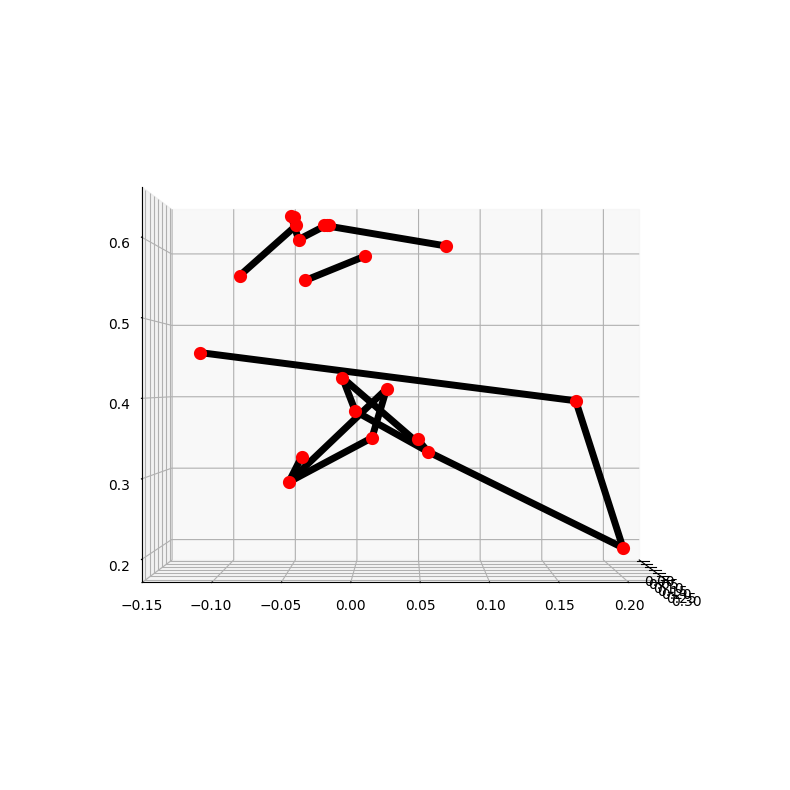

Human figure detected.


In [3]:
 # Human figure detection

 import cv2

 import mediapipe as mp
 import numpy as np


 mp_drawing = mp.solutions.drawing_utils
 mp_drawing_styles = mp.solutions.drawing_styles
 mp_pose = mp.solutions.pose

 def pose():

  # For static images:
  IMAGE_FILES = [
    '/content/drive/MyDrive/project_dataset/pose_detection/postive/Photo on 15.03.24 at 15.13 #2.jpg',
  ]

  BG_COLOR = (192, 192, 192) # gray
  with mp_pose.Pose(
    static_image_mode=True,
    model_complexity=2,
    enable_segmentation=True,
    min_detection_confidence=0.5) as pose:
    for idx, file in enumerate(IMAGE_FILES):
      print(f'File: {file}')
      image = cv2.imread(file)
      image_height, image_width, _ = image.shape
      # Convert the BGR image to RGB before processing.
      results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      if not results.pose_landmarks:
          print('No results')
          continue
      landmarks=results.pose_world_landmarks.landmark
      noseIndex=mp_pose.PoseLandmark.NOSE



      annotated_image = image.copy()
      # Draw segmentation on the image.
      # bilateral filter to "results.segmentation_mask" with "image".
      condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
      bg_image = np.zeros(image.shape, dtype=np.uint8)
      bg_image[:] = BG_COLOR
      annotated_image = np.where(condition, annotated_image, bg_image)
      # Draw pose landmarks on image.
      mp_drawing.draw_landmarks(
          annotated_image,
          results.pose_landmarks,
          mp_pose.POSE_CONNECTIONS,
          landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
      cv2.imwrite('/tmp/annotated_image' + str(idx) + '.png', annotated_image)
      # Plot pose world landmarks.
      mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS, elevation=0, azimuth=0)
    if not results.pose_landmarks:
      print('No human figure detected.')
    else:
      print('Human figure detected.')

 if __name__ == '__main__':
   pose()
#3D

In [4]:

# Classifer trained and selected: is it a happy face or anything else
# Output:
# - correct pose
# - Other poses
# - No pose landmarks

In [5]:
# Transform the images:

import cv2
import mediapipe as mp
import numpy as np
import os

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

def process_images_from_folder(folder_path, label):
    features = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = pose.process(image_rgb)

            if results.pose_landmarks:
                landmark_list = results.pose_landmarks.landmark
                landmarks = np.array([(landmark.x, landmark.y, landmark.z) for landmark in landmark_list]).flatten()
                features.append(landmarks)
                labels.append(label)
    return features, labels

correct_pose_folder = '/content/drive/MyDrive/project_dataset/pose_detection/postive'
# other_folder = '/content/drive/MyDrive/mlTrainingSetImages/Neutral'
other_folder = '/content/drive/MyDrive/project_dataset/pose_detection/negative'


features_y1, labels_y1 = process_images_from_folder(correct_pose_folder, 1)
features_y0, labels_y0 = process_images_from_folder(other_folder, 0)


#Train pose detection model

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = np.array(features_y1 + features_y0)
y = np.array(labels_y1 + labels_y0)


# Split dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
classifier = RandomForestClassifier()

# Train the model
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')


Accuracy: 1.0


In [7]:
#Testing function:

def process_and_predict(image_path, classifier):
    # Load image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process image to detect pose landmarks
    results = pose.process(image_rgb)

    # Check if landmarks were detected
    if results.pose_landmarks:
        # Extract and flatten landmarks
        landmark_list = results.pose_landmarks.landmark
        landmarks = np.array([(landmark.x, landmark.y, landmark.z) for landmark in landmark_list]).flatten()

        # Predict label for the new image
        prediction = classifier.predict([landmarks])
        return prediction[0]  # Return predicted label
    else:
        print("No pose landmarks detected in the image.")
        return None


In [8]:
new_image_path = '/content/drive/MyDrive/project_dataset/pose_detection/postive/Photo on 15.03.24 at 21.24 #7.jpg' #update the path

# Assuming 'classifier' is trained model
predicted_label = process_and_predict(new_image_path, classifier)

if predicted_label is not None:
    print(f"Predicted label: {'This is the transformer pose' if predicted_label == 1 else 'Neutral pose'}")

Predicted label: This is the transformer pose


#**Part 3**

- Capture live images and apply the claffier we training above to classify the pose

In [9]:
import os

folder_path = "/content/screenshots_test"
os.makedirs(folder_path, exist_ok=True)
print(f"Folder created at: {folder_path}")

Folder created at: /content/screenshots_test


In [11]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
import base64
from time import sleep

# JavaScript to capture a single image
js = Javascript('''
    async function captureImage() {
        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Wait for the video to start playing
        await new Promise(resolve => setTimeout(resolve, 3000));

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        video.remove();

        return canvas.toDataURL('image/jpeg');
    }
''')

# Function to capture and save an image
def capture_and_save_image(image_index):
    display(js)  # Display the JavaScript interface for capturing an image
    image_data_url = eval_js('captureImage()')  # Capture the image
    image_data = base64.b64decode(image_data_url.split(',')[1])

    image_path = f"{folder_path}/image_{image_index}.jpg"
    with open(image_path, 'wb') as f:
        f.write(image_data)
    print(f"Image {image_index} saved at {image_path}")
    return image_path

# Capture and save 5 images at 4-second intervals
for i in range(5,6):
    new_image_path = capture_and_save_image(i+1)
    if i < 4:  # Wait for 4 seconds between captures, but not after the last one
        sleep(4)



<IPython.core.display.Javascript object>

Image 6 saved at /content/screenshots_test/image_6.jpg


In [12]:
new_image_path = '/content/screenshots_test/image_6.jpg'
# Assuming 'classifier' is trained model
predicted_label = process_and_predict(new_image_path, classifier)
print(predicted_label)
if predicted_label is not None:
    print(f"Predicted label: {'This is transformer pose' if predicted_label == 1 else 'Neutral poses'}")

0
Predicted label: Neutral poses


#**Final Part**
- Combine all the models on a live recorded images and live recorded voice
- if it is the right pose and the right work "go", transform the image. if not don't do anything

## Combining everyhting all togther

# Step 1: the Pose detection

In [13]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
import base64
from time import sleep
import os

folder_path = "/content/screenshots_test"
os.makedirs(folder_path, exist_ok=True)
print(f"Folder created at: {folder_path}")



# JavaScript to capture a single image
js = Javascript('''
    async function captureImage() {
        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Wait for the video to start playing
        await new Promise(resolve => setTimeout(resolve, 3000));

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        video.remove();

        return canvas.toDataURL('image/jpeg');
    }
''')

# Function to capture and save an image
def capture_and_save_image(image_index):
    display(js)  # Display the JavaScript interface for capturing an image
    image_data_url = eval_js('captureImage()')  # Capture the image
    image_data = base64.b64decode(image_data_url.split(',')[1])

    image_path = f"{folder_path}/image_{image_index}.jpg"
    with open(image_path, 'wb') as f:
        f.write(image_data)
    print(f"Image {image_index} saved at {image_path}")
    return image_path
# Capture and save 5 images at 4-second intervals
for i in range(5,6):
    new_image_path = capture_and_save_image(i+1)
    if i < 4:  # Wait for 4 seconds between captures, but not after the last one
        sleep(4)




Folder created at: /content/screenshots_test


<IPython.core.display.Javascript object>

Image 6 saved at /content/screenshots_test/image_6.jpg


In [14]:
# Assuming 'classifier' is your trained model
predicted_label = process_and_predict(new_image_path, classifier)

if predicted_label is not None:
    pose_flag  = predicted_label
    print(f"Predicted label: {'Pose with an SMILE pose' if predicted_label == 1 else 'Neutral poses'}")

Predicted label: Neutral poses


# Step 2: the Audio detection

In [15]:

from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

# This function will be called later to save the audio file
def record_audio(filename):
  js = Javascript("""
    async function recordAudio() {
      // Prompt the user for permission, get the audio stream
      const stream = await navigator.mediaDevices.getUserMedia({audio: true});
      // Create a MediaRecorder instance
      const recorder = new MediaRecorder(stream);
      const data = [];

      // Push audio chunks into our data array on dataavailable event
      recorder.ondataavailable = event => data.push(event.data);

      // Stop recording after 1 second and resolve the Promise
      recorder.start();
      await new Promise(resolve => setTimeout(resolve, 1000)); // Set duration here
      recorder.stop();

      // Wait for the stop event to ensure we have all the data
      return new Promise(resolve => recorder.onstop = resolve)
        .then(() => data);
    }

    async function saveAudio() {
      const data = await recordAudio();
      const audio = new Blob(data, { type: 'audio/webm' });
      const reader = new FileReader();
      reader.readAsDataURL(audio);
      reader.onloadend = () => {
        const base64AudioMessage = reader.result.split(',')[1];
        google.colab.kernel.invokeFunction('notebook.RecordAudio', [base64AudioMessage], {});
      };
    }
    saveAudio()
  """)
  display(js)

# This function will be invoked from JavaScript, receives the audio data as base64
def record_audio_base64(base64AudioMessage):
  audio_bytes = b64decode(base64AudioMessage)
  with open(filename, 'wb') as f:
    f.write(audio_bytes)

# Register the callback function that saves the audio
output.register_callback('notebook.RecordAudio', record_audio_base64)






In [16]:
folder_path = "/content/test_audio/"
os.makedirs(folder_path, exist_ok=True)
print(f"Folder created at: {folder_path}")

Folder created at: /content/test_audio/


In [17]:
filename = '/content/test_audio_main.wav'
record_audio(filename)


<IPython.core.display.Javascript object>

In [18]:
## function to predict text


import numpy as np
import librosa

# Function to load and preprocess the audio
def preprocess_audio(filename):
    # Load the audio file
    audio, sr = librosa.load(filename, sr=8000)  # Ensure audio is loaded at 8 kHz
    # If the audio is too long, trim it to the first 8000 samples
    if len(audio) > 8000:
        audio = audio[:8000]
    # If the audio is too short, pad it with zeros to 8000 samples
    elif len(audio) < 8000:
        audio = np.pad(audio, (0, 8000 - len(audio)), 'constant')
    # Reshape audio for the model
    audio = audio.reshape(1, 8000, 1)
    return audio



def predict(audio):

    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [19]:
import numpy as np
import librosa
import os

# Define the classes corresponding to your model's output
classes = ['not_go', 'go']  # Update this list according to your model's training

def predict(audio):
    prob = model.predict(audio)
    index = np.argmax(prob[0])
    return classes[index]

def preprocess_audio(filename):
    if not os.path.exists(filename):
        print("File not found:", filename)
        return None
    # Load the audio file
    audio, sr = librosa.load(filename, sr=8000)  # Ensure audio is loaded at 8 kHz
    # If the audio is too long, trim it to the first 8000 samples
    if len(audio) > 8000:
        audio = audio[:8000]
    # If the audio is too short, pad it with zeros to 8000 samples
    elif len(audio) < 8000:
        audio = np.pad(audio, (0, 8000 - len(audio)), 'constant')
    # Reshape audio for the model
    return audio.reshape(1, 8000, 1)

# Load and preprocess your recorded audio
if os.path.exists(filename):
    preprocessed_audio = preprocess_audio(filename)
    if preprocessed_audio is not None:
        prediction = predict(preprocessed_audio)
        print("Predicted Text:", prediction)
        audio_flag = 1 if prediction == "go" else 0
        print(audio_flag)
    else:
        print("Error processing audio.")
else:
    print("Recorded audio file does not exist.")


Recorded audio file does not exist.


In [20]:
from IPython.display import Image, display
import cv2
import os

# Ensure the output directory exists
output_dir = "/content/screenshots"
os.makedirs(output_dir, exist_ok=True)

if audio_flag == 1 and pose_flag == 1:
    print("Transform")

    # Load and apply the effect
    image = cv2.imread(new_image_path)
    print("Attempting to load image from:", new_image_path)  # Debug print

    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Apply effect (assuming apply_godrays is defined elsewhere)
        light_pos = (image.shape[1] // 2, image.shape[0] // 4)  # Example light position
        godrays_image = apply_godrays(image, light_pos)

        # Save the processed image
        output_path = os.path.join(output_dir, "/content/screenshots_test/image_6_custom_artistic.jpg")
        cv2.imwrite(output_path, cv2.cvtColor(godrays_image, cv2.COLOR_RGB2BGR))  # Convert back to BGR for saving

        # Display the image
        display(Image(filename=output_path))
    else:
        print("Image not found. Please check the path.")
else:
    print("Do not transform")


NameError: name 'audio_flag' is not defined